# Ethi Medical Products Object Detection

**YOLOv5 Object Detection Training Notebook**

**Step 1: Environment Setup and Imports**

First, we'll import the necessary libraries and set up the environment.

In [1]:
# Import libraries for file handling and data splitting
import os, sys
import random
import shutil
# Verify if the environment is set up properly
# Ensure the necessary dependencies are installed like torch, torchvision, and other YOLOv5 requirements
#!pip install opencv-python torch torchvision
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from logger import Logger
# Set instance of the Logger class
logger = Logger(log_file='../yolo_training.log')
sys.path.append('../yolov5')  # Adjust the path based on your directory structure

**Step 2: Define Paths and Prepare Directories**

We define the paths for the source images and create directories for the training and validation sets.

In [2]:
# Define the directory paths
photos_dir = '../data/photos'  # Directory containing all your images
train_dir = '../data/train/images'  # Directory for training images
val_dir = '../data/valid/images'  # Directory for validation images


try:
    # Create directories for train and validation sets if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Print the number of images available
    print(f"Total images available: {len(os.listdir(photos_dir))}")
    logger.info(f'{len(os.listdir(photos_dir))} total images available in {photos_dir}')
except Exception as e:
    logger.info(f'Error: {e}')


Total images available: 567


**Step 3: Split the Dataset**

Split the images into training and validation datasets with a specified ratio (default is 80% training, 20% validation).

In [3]:
def split_dataset(source_dir, train_dir, val_dir, split_ratio=0.8):
    # List all images in the source directory
    images = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]
    random.shuffle(images)  # Shuffle the images for random selection

    # Calculate the split index
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    val_images = images[split_index:]

    # Copy images to the respective directories
    for image in train_images:
        shutil.copy(os.path.join(source_dir, image), train_dir)
    for image in val_images:
        shutil.copy(os.path.join(source_dir, image), val_dir)
    
    print(f"Training images: {len(train_images)}")
    print(f"Validation images: {len(val_images)}")


if __name__=='__main__':
    
    try:
        # Call the function to split the dataset
        split_dataset(photos_dir, train_dir, val_dir)
        logger.info(f'Splited the dataset into train and validation sets.')
    except Exception as e:
        logger.info(f'Error: {e}')


Training images: 453
Validation images: 114


**Step 4: Prepare YOLOv5 Environment**

Clone the YOLOv5 repository if it isn't already cloned, and install the necessary requirements.

In [4]:
# Clone the YOLOv5 repository (only run this if you don't have YOLOv5 cloned already)

# uncomment below line, and run the cell

#!git clone https://github.com/ultralytics/yolov5.git

# Change the working directory to yolov5

# uncomment below line, and run the cell
#%cd yolov5

# Install required packages for YOLOv5
# uncomment below line, and run the cell

#!pip install -r requirements.txt

#' to automatically track and visualize YOLOv5 🚀 runs in Comet
# uncomment below line, and run the cell
#%pip install comet_ml


**Step 5: Create the Data YAML File**

The YAML file will define paths to training and validation data, the number of classes, and their names.

In [4]:
# Define the content of the YAML file
yaml_content = """
train: D:/KMAI3/EMB-DataWarehouse/data/train/images  # Update this if you have a separate directory for training
val: D:/KMAI3/EMB-DataWarehouse/data/valid/images    # Update this if you have a separate directory for validation

nc: 9  # Number of classes
names: [
  'cosmotic',
  'food-package', 
  'supliment', 
  'formula-milk', 
  'lotion-moisturizer', 
  'medicine', 
  'mini-drop', 
  'pregnancy', 
  'other'
]
"""

# Write the content to a file
with open("medical_dataset.yml", "w") as file:
    file.write(yaml_content)

# Verify the file was created

print(os.path.exists("medical_dataset.yml"))  # Should return True

# Check the existence of the image directory
print(os.path.exists('D:/KMAI3/EMB-DataWarehouse/data/train/images'))

True
True


**Step 6: Train the YOLOv5 Model**

Train the model using the dataset and configuration set up in the previous steps.

Downloading labeled dataset from roboflow

In [5]:
# Install requirements
#%pip install ultralytics roboflow

# Download dataset (same as YOLOv5)
from roboflow import Roboflow
rf = Roboflow(api_key="eDraTy7oHELDj6QbeQ2L")
project = rf.workspace("medical-products").project("medical-products")
version = project.version(1)
dataset = version.download("yolov8")  # Changed to yolov8 format


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to medical-products-1 in yolov8:: 100%|██████████| 392/392 [00:00<00:00, 2007.19it/s]


In [6]:
# Base training command (yolov8s)
from ultralytics import YOLO

# Load model
model = YOLO("yolov8s.pt")  # YOLOv8 small model

100%|██████████| 21.5M/21.5M [00:03<00:00, 6.22MB/s]


In [7]:
# Train with parameters
model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=5,
    imgsz=640,
    batch=16,
    name="fine_tuned_model",
    project="medical-detection"
)

Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=d:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=medical-detection, name=fine_tuned_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False,

train: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\train\labels... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<00:00, 304.31it/s]

train: New cache created: D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\train\labels.cache
WARNING  Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 177. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\valid\labels... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 361.05it/s]

val: New cache created: D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\valid\labels.cache


Plotting labels to medical-detection\fine_tuned_model\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to medical-detection\fine_tuned_model
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G       1.59       6.57      1.882         15        640: 100%|██████████| 9/9 [01:33<00:00, 10.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.92s/it]

                   all         38         55      0.354     0.0833     0.0697     0.0395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.132      3.338       1.46         17        640: 100%|██████████| 9/9 [01:31<00:00, 10.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:15<00:00,  7.96s/it]

                   all         38         55      0.337     0.0774     0.0238     0.0156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.024      2.741      1.405         19        640: 100%|██████████| 9/9 [01:42<00:00, 11.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.93s/it]

                   all         38         55      0.467      0.185      0.124     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G     0.8789       2.29      1.267         14        640: 100%|██████████| 9/9 [01:04<00:00,  7.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.91s/it]

                   all         38         55      0.162      0.499      0.201      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.8849      2.207      1.323         10        640: 100%|██████████| 9/9 [01:04<00:00,  7.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.52s/it]

                   all         38         55      0.248       0.37      0.254      0.201



5 epochs completed in 0.137 hours.
Optimizer stripped from medical-detection\fine_tuned_model\weights\last.pt, 22.5MB
Optimizer stripped from medical-detection\fine_tuned_model\weights\best.pt, 22.5MB

Validating medical-detection\fine_tuned_model\weights\best.pt...
Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 168 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.50s/it]


                   all         38         55      0.251      0.372      0.253      0.202
              cosmotic          4          6     0.0328     0.0601      0.047     0.0392
          food-package          3          3     0.0967      0.333      0.132      0.105
        food-supliment         16         24       0.36      0.625      0.357      0.248
          formula-milk          8          8      0.203       0.75      0.403       0.36
       lotion-moisture          4          4      0.244        0.5      0.289      0.203
              medicine          6          7          0          0     0.0966     0.0516
             mini-drop          2          3      0.823      0.333       0.45      0.405
Speed: 1.1ms preprocess, 162.2ms inference, 0.0ms loss, 118.5ms postprocess per image
Results saved to medical-detection\fine_tuned_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001DFC5B78E00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047

In [8]:
# Training with different model sizes
models = {
    "yolov8n": (320, 8),  # nano model
    "yolov8s": (640, 16),  # small model
    "yolov8m": (640, 16)   # medium model
}
for model_name, (imgsz, batch) in models.items():
    model = YOLO(f"{model_name}.pt")
    model.train(
        data=f"{dataset.location}/data.yaml",
        epochs=5,
        imgsz=imgsz,
        batch=batch,
        name=f"fine_tuned_{model_name}",
        project="medical-detection"
    )

100%|██████████| 6.25M/6.25M [00:00<00:00, 6.83MB/s]


Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=d:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1/data.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=medical-detection, name=fine_tuned_yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False

train: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\train\labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 177. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\valid\labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]

Plotting labels to medical-detection\fine_tuned_yolov8n\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to medical-detection\fine_tuned_yolov8n
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.396      3.612       1.45         10        320: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         38         55    0.00562      0.935      0.189      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.055      3.339      1.222         18        320: 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

                   all         38         55    0.00569      0.893      0.188      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.002      3.064      1.213         16        320: 100%|██████████| 17/17 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

                   all         38         55     0.0633      0.792      0.199      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G     0.9445      2.944      1.169         16        320: 100%|██████████| 17/17 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         38         55       0.83      0.143      0.213      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.9238       2.91      1.179         12        320: 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         38         55      0.816      0.202      0.213      0.169



5 epochs completed in 0.012 hours.
Optimizer stripped from medical-detection\fine_tuned_yolov8n\weights\last.pt, 6.2MB
Optimizer stripped from medical-detection\fine_tuned_yolov8n\weights\best.pt, 6.2MB

Validating medical-detection\fine_tuned_yolov8n\weights\best.pt...
Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


                   all         38         55      0.816      0.202      0.211      0.168
              cosmotic          4          6          1          0      0.213      0.144
          food-package          3          3          1          0     0.0525     0.0446
        food-supliment         16         24      0.454      0.542      0.377      0.269
          formula-milk          8          8      0.258      0.875      0.549      0.489
       lotion-moisture          4          4          1          0     0.0885     0.0651
              medicine          6          7          1          0      0.155      0.121
             mini-drop          2          3          1          0     0.0446     0.0406
Speed: 0.8ms preprocess, 13.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to medical-detection\fine_tuned_yolov8n
Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8

train: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\train\labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 177. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\valid\labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]

Plotting labels to medical-detection\fine_tuned_yolov8s\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to medical-detection\fine_tuned_yolov8s
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.606      6.813      1.876         10        640: 100%|██████████| 9/9 [01:04<00:00,  7.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.87s/it]

                   all         38         55      0.261      0.101     0.0909     0.0574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G       1.17      3.569       1.58         12        640: 100%|██████████| 9/9 [01:05<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.07s/it]

                   all         38         55       0.58      0.182      0.117     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G     0.9594       2.81      1.395         16        640: 100%|██████████| 9/9 [01:07<00:00,  7.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.73s/it]

                   all         38         55      0.628      0.292      0.241      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      0.911       2.41      1.332         16        640: 100%|██████████| 9/9 [01:09<00:00,  7.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.04s/it]

                   all         38         55      0.304      0.354      0.226       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.8497      2.303      1.263         13        640: 100%|██████████| 9/9 [01:02<00:00,  6.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.22s/it]

                   all         38         55      0.204      0.416      0.252      0.184



5 epochs completed in 0.110 hours.
Optimizer stripped from medical-detection\fine_tuned_yolov8s\weights\last.pt, 22.5MB
Optimizer stripped from medical-detection\fine_tuned_yolov8s\weights\best.pt, 22.5MB

Validating medical-detection\fine_tuned_yolov8s\weights\best.pt...
Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 168 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


                   all         38         55      0.202      0.417      0.252      0.184
              cosmotic          4          6      0.168      0.667      0.196      0.122
          food-package          3          3          0          0     0.0519     0.0357
        food-supliment         16         24       0.54      0.542       0.43      0.284
          formula-milk          8          8      0.379      0.875      0.663      0.562
       lotion-moisture          4          4      0.134        0.5       0.19      0.139
              medicine          6          7          0          0      0.149     0.0803
             mini-drop          2          3      0.193      0.333     0.0854     0.0619
Speed: 1.6ms preprocess, 154.5ms inference, 0.0ms loss, 114.2ms postprocess per image
Results saved to medical-detection\fine_tuned_yolov8s


100%|██████████| 49.7M/49.7M [00:18<00:00, 2.75MB/s]


Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=d:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=medical-detection, name=fine_tuned_yolov8m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

train: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\train\labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 177. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning D:\KMAI3\EMB-DataWarehouse\notebbooks\medical-products-1\valid\labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]

Plotting labels to medical-detection\fine_tuned_yolov8m\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to medical-detection\fine_tuned_yolov8m
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.283      4.242      1.667         10        640: 100%|██████████| 9/9 [03:33<00:00, 23.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING  NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:19<00:19, 19.14s/it]

WARNING  NMS time limit 2.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:23<00:00, 11.90s/it]

                   all         38         55      0.121      0.245     0.0947     0.0586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G     0.9104      3.066      1.392         12        640: 100%|██████████| 9/9 [03:10<00:00, 21.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.86s/it]

                   all         38         55      0.188      0.509      0.207      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G     0.7974      2.417      1.268         16        640: 100%|██████████| 9/9 [02:57<00:00, 19.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.51s/it]

                   all         38         55      0.218      0.585      0.231      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G     0.7868       2.09      1.241         16        640: 100%|██████████| 9/9 [02:39<00:00, 17.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.21s/it]

                   all         38         55      0.303      0.431      0.304      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.8027      1.981      1.224         13        640: 100%|██████████| 9/9 [02:52<00:00, 19.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.19s/it]

                   all         38         55      0.218       0.47      0.309      0.221



5 epochs completed in 0.285 hours.
Optimizer stripped from medical-detection\fine_tuned_yolov8m\weights\last.pt, 52.0MB
Optimizer stripped from medical-detection\fine_tuned_yolov8m\weights\best.pt, 52.0MB

Validating medical-detection\fine_tuned_yolov8m\weights\best.pt...
Ultralytics 8.3.70  Python-3.12.8 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i5-11320H 3.20GHz)
Model summary (fused): 218 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.80s/it]


                   all         38         55      0.217       0.47      0.309      0.221
              cosmotic          4          6     0.0351      0.167      0.107     0.0796
          food-package          3          3      0.182      0.333       0.17      0.153
        food-supliment         16         24      0.483      0.428      0.429      0.305
          formula-milk          8          8      0.419      0.875      0.446      0.363
       lotion-moisture          4          4     0.0691       0.25      0.209       0.18
              medicine          6          7      0.104      0.571      0.131     0.0822
             mini-drop          2          3      0.226      0.667      0.667      0.386
Speed: 1.3ms preprocess, 431.6ms inference, 0.0ms loss, 22.5ms postprocess per image
Results saved to medical-detection\fine_tuned_yolov8m


In [9]:
# Detection with best model
best_model = YOLO("medical-detection/fine_tuned_model/weights/best.pt")
results = best_model.predict(
    source="../data/photos",
    conf=0.25,
    save=True,
    save_txt=True,
    save_conf=True,
    imgsz=320,
    name="predictions"
)



image 1/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_10.jpg: 320x320 1 food-package, 1 lotion-moisture, 1 medicine, 106.2ms
image 2/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_11.jpg: 320x320 1 food-package, 1 formula-milk, 57.3ms
image 3/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_13.jpg: 320x320 1 formula-milk, 61.4ms
image 4/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_14.jpg: 320x256 1 formula-milk, 1 medicine, 67.3ms
image 5/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_15.jpg: 320x320 1 formula-milk, 1 medicine, 49.3ms
image 6/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_17.jpg: 320x256 1 formula-milk, 1 medicine, 46.4ms
image 7/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_18.jpg: 288x320 2 medicines, 87.9ms
image 8/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_19.jpg: 256x320 1 food-package, 71.6ms
image 

In [10]:
# Additional detection example with different img size
results = best_model.predict(
    source="../data/photos",
    conf=0.3,  # Higher confidence threshold
    imgsz=640,
    save=True,
    name="highres_predictions"
)


image 1/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_10.jpg: 640x640 1 food-supliment, 157.4ms
image 2/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_11.jpg: 640x640 (no detections), 179.1ms
image 3/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_13.jpg: 640x640 (no detections), 130.8ms
image 4/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_14.jpg: 640x480 1 formula-milk, 118.3ms
image 5/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_15.jpg: 640x640 1 food-supliment, 1 pregnancy, 105.5ms
image 6/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_17.jpg: 640x480 1 formula-milk, 80.4ms
image 7/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_18.jpg: 544x640 3 formula-milks, 132.7ms
image 8/567 d:\KMAI3\EMB-DataWarehouse\notebbooks\..\data\photos\CheMed123_19.jpg: 480x640 1 food-supliment, 1 pregnancy, 119.3ms
image 9/567 d:\KMAI3\EMB-DataWarehouse\notebb

**Use a Pretrained Model (Transfer Learning)**

Fine-tuning a smaller pre-trained model (like yolov5n.pt or yolov5s.pt instead of larger models like yolov5x.pt) will use less memory:
- Decrease the Batch Size
- Reduce Image Size

**Step 5: Processing the Detection Results**

Extract relevant data from the detection results, such as bounding box coordinates, confidence scores, and class labels.

To process detection results using YOLOv5 and extract relevant data, we can modify the inference script (detect.py) or create a custom script that reads the detection outputs. Below is a step-by-step guide:

**Step 1: Predict the the whole images dataset**

Based on the transfer learning and trained small subset of the labeled data, predict the whole images

**Storing detection data to a database table**

In [13]:
!python ../scripts/store_detection_results.py


Connection to the database established successfully.
Detection results stored successfully.


Display the results in the plot

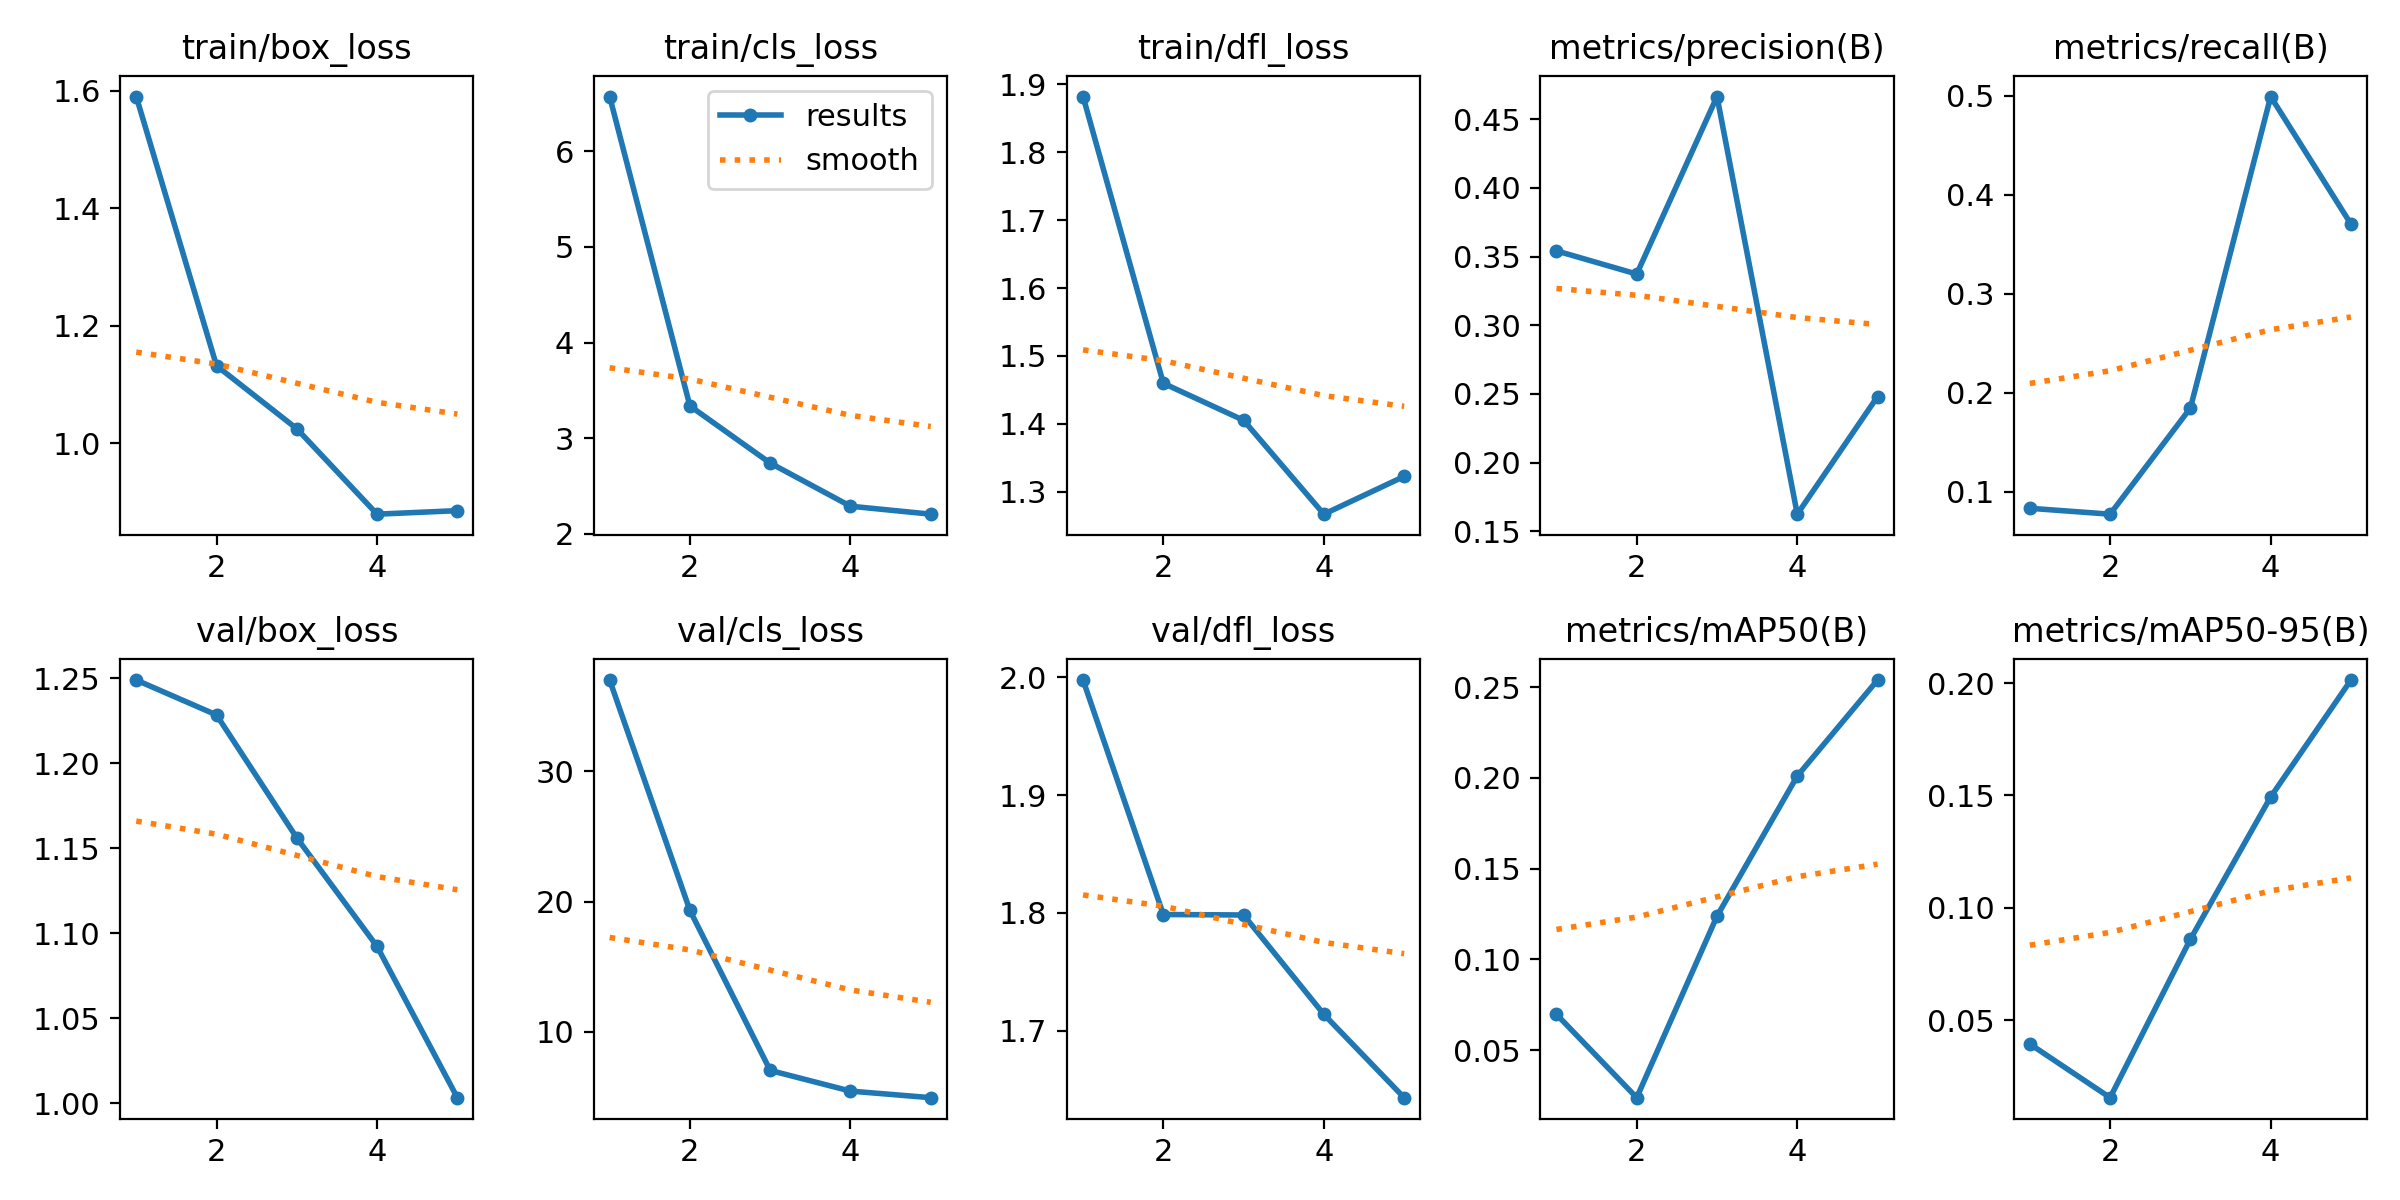

In [23]:
from IPython.display import Image, display

# Replace this with the path to your PNG results
png_file_path = 'medical-detection/fine_tuned_model/results.png'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))


In [ ]:
# Replace this with the path to your PNG results
png_file_path = 'medical-detection/fine_tuned_model/labels.jpg'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))

In [ ]:
# Replace this with the path to your PNG results
png_file_path = '../yolov5/runs/train/fine_tuned_model12/confusion_matrix.png'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))

In [ ]:
# Replace this with the path to your PNG results
png_file_path = '../yolov5/runs/train/fine_tuned_model12/labels_correlogram.jpg'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))

In [ ]:
# Replace this with the path to your PNG results
png_file_path = '../yolov5/runs/train/fine_tuned_model12/F1_curve.png'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))

In [ ]:
# Replace this with the path to your PNG results
png_file_path = '../yolov5/runs/train/fine_tuned_model12/P_curve.png'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))

In [ ]:
# Replace this with the path to your PNG results
png_file_path = '../yolov5/runs/train/fine_tuned_model12/PR_curve.png'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))

In [ ]:
# Replace this with the path to your PNG results
png_file_path = '../yolov5/runs/train/fine_tuned_model12/R_curve.png'  # Adjust the path accordingly

# Display the PNG image
display(Image(filename=png_file_path))